# End - to - End Deep Learning
- End-to-End (or) E2E deep learning is one of the most exciting recent developments in deep learning. Briefly, there have been data processing or learning systems that require multiple stages of learning and processing.
- What E2E DL does is, it replaces all the multiple stages with a single Neural Network.
- Applications of E2E DL include `speech recognition`, `facial recognition`, `machine translation`, `handwriting recognition` etc...
- In this notebook, we will explore `Optical Character Recognition` which is one of the hardest tasks in Deep Learning.

<img border='4' src="http://blog.easysol.net/wp-content/uploads/2017/06/image2-600x228.png" style="width:700px;height:400px;">
<caption><center> **Figure 1**: Traditional Systems vs E2E Deep Learning for speech recognition </center></caption>


# 1 - Optical Character Recognition 

- Optical character recognition, or OCR is the process of mechanically or electronically converting scanned images of handwritten, typed or printed text in machine-encoded text

- The technology deals with the problem of recognizing all different kinds of characters. Both handwritten and printed characters can be recognized and converted into machine readable text.

- Think of any kind of serial number or code consisting of numbers and letters that you need digitized. By using OCR you can transform those codes into digital output. The technology makes use of different techniques. Put in a very simplified way, the image taken will be preprocessed and the characters extracted and recognized.


<img src="https://upload.wikimedia.org/wikipedia/commons/a/a8/Letter_by_Ben_Franklin.jpg" style="width:300px;height:400px;">
<caption><center> **Figure 2 **:  A Letter by Benjamin Franklin </center></caption>


<img src="https://i.ytimg.com/vi/-_cRuSWFmCY/maxresdefault.jpg" style="width:300px;height:200px;">
<caption><center> **Figure 3 **:  Character recognition of a license plate </center></caption>

In [1]:
# Some portions of this notebook are inspired from francois chollet's 
# (https://github.com/keras-team/keras/blob/master/examples/image_ocr.py)

import os 
from os.path import join
import json
import numpy as np
import cv2
import random
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model, model_from_json
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks

%matplotlib inline

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Initialize `Session()` so that the trained model can be evaluated/ used to make predictions(see 1.8) on test images later

In [2]:
import tensorflow as tf

sess = tf.Session()
K.set_session(sess)

## 1.1 -  Let's take a look at an image we will  work on later

- Data can be downloaded from (https://supervise.ly/)
- Here we use a dataset of car number plates, all the samples  are of similar in shape, size and structure.

Contents of the json_file :  {'description': 'A001CB06', 'tags': [], 'objects': [], 'size': {'height': 34, 'width': 152}, 'name': 'A001CB06'}
Contents of the Image :  A001CB06


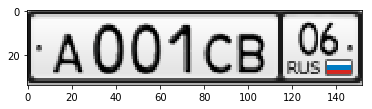

In [3]:
sample_json_file = json.load(open('data/train/ann/A001CB06.json'))
sample_img = Image.open('data/train/img/A001CB06.png')

print("Contents of the json_file : ", sample_json_file)
print("Contents of the Image : ", sample_json_file['description'])
plt.imshow(sample_img)

## 1.2 - Attributes of the dataset

- os.path module documentation (https://docs.python.org/2/library/os.path.html)

In [4]:
def get_counter(dir_path):
    
    # directory where annotations are located
    annotations_dirpath = join(dir_path, 'ann')
    letters = ''       # stores all the letters from the dataset
    lens = []          # stores length of each number plate
    
    
    # loop over all the annotations in the folder
    for filename in os.listdir(annotations_dirpath):
        json_filepath = join(annotations_dirpath, filename)
        description = json.load(open(json_filepath, 'r'))['description']
        lens.append(len(description))
        letters += description
        
    print("Maximum length of the Number plate in %s :"%(annotations_dirpath),max(Counter(lens).keys()))
    print("Number of examples in %s :"%(annotations_dirpath), len(lens))
    print()
    
    return Counter(letters)   # returns a dictionary of unique letters(keys) with number of occurences(values)

In [5]:
c_train = get_counter('data/train/')
c_val = get_counter('data/val/')


letters_train = set(c_train.keys())
letters_val = set(c_val.keys())


# Checks whether the length of letters in each set is same
if letters_train == letters_val:
    print("\n\n***Letters in train set and validation set match***\n")
else:
    raise Exception()
    
letters = sorted(list(letters_train))
print(len(letters)," Letters : ", ' '.join(letters))

Maximum length of the Number plate in data/train/ann : 8
Number of examples in data/train/ann : 10273

Maximum length of the Number plate in data/val/ann : 8
Number of examples in data/val/ann : 548



***Letters in train set and validation set match***

22  Letters :  0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y


<font color='blue'>
** Observations : **
- Maximum length of the Number plate in the dataset is 8
- Letters used in the dataset `0 1 2 3 4 5 6 7 8 9 A B C E H K M O P T X Y`

# 1.3 - Input data generator

<font color='green'>
- As our training data is huge (10K examples), It will be difficult to fit all of them into memory at once.
- We'll build a generator function that yields a training example/batch_of_them each time the function is called.

In [6]:
# converts text to labels
def text_to_labels(text):
    
    labels = []
    for letter in text:
        labels.append(letters.index(letter))
    return labels

# converts labels to text
def labels_to_text(labels):
    
    text = ""
    for index in labels:
        text += letters[int(index)]
    return text

# checks each sample for characters
def is_valid_str(s):
    
    for char in s:
        if char not in letters:
            return False
    return True

In [7]:
sample_text = 'A001CB06'
sample_labels = text_to_labels(sample_text)

sample_text_out = labels_to_text(sample_labels)
print("sample_text_out : ", sample_text_out, "\nsample_labels   : ", sample_labels)

sample_text_out :  A001CB06 
sample_labels   :  [10, 0, 0, 1, 12, 11, 0, 6]


- The `text_to_labels()` function converts a given string of text into a list of labels. This will be useful in converting text in number plates to labels with indices from the letters_list.
- The `labels_to_text()` function converts a list a labels output by the model into a string of text. 
- The `is_valid_str()` function ensures that we process images with characters only from `letters`.

### 1.3.1 - Batch Generator

In [8]:
class TextImageGenerator:
    
    def __init__(self, dirpath, img_w, img_h, batch_size, downsample_factor, max_text_len=8):
        
        self.img_w = img_w  # image_width
        self.img_h = img_h  # image_height
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor # factor to reduce the size of the images
        self.max_text_len = max_text_len
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        
        self.samples = []     # stores img_filepath, description
        
        for filename in os.listdir(img_dirpath):             # loops over all the samples
            name, extension = os.path.splitext(filename)     # splits 'A001CB06.png' to 'A001CB06' , '.png'
            if extension =='.png':
                img_filepath = join(img_dirpath, filename)   
                json_filepath = join(ann_dirpath, name + '.json')
                description = json.load(open(json_filepath, 'r'))['description']
                
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
        
        # Number of samples in dataset
        self.n = len(self.samples)                
        self.indices = list(range(self.n))        # indices of all samples
        self.current_index = 0                    # set current_index to 0
        
    def build_data(self):
            
        # Rank 3 tensor storing images
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
            
        for index, (img_filepath, description) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = img/255
                
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
                
            self.imgs[index, :, :] = img        # store the img with index in imgs
            self.texts.append(description)      # Also store the corresponding description
                
     
    # defines output_size of the model(we add +1 because the ctc loss outputs a blank character)
    def get_output_size(self):
        return len(letters) + 1
        
    # returns number of samples from the set    
    def n_samples(self):
        return self.n
        
    # returns a sample    
    def next_sample(self):
        self.current_index += 1
            
        # if looped over all the samples then  output a random sample
        if self.current_index >= self.n:
            self.current_index = 0
            random.shuffle(self.indices)   
        # outputs next_sample
        return self.imgs[self.indices[self.current_index]], self.texts[self.indices[self.current_index]]
        
        
    # generator function : returns a batch of samples every time if called    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
                
            # image_data_format() = 'channels_last' for keras with tensorflow backend (n,h,w,c)
            X_data = np.ones((self.batch_size, self.img_w, self.img_h, 1))    # images data.shape (8, w, h, 1)
            Y_data = np.ones((self.batch_size, self.max_text_len))            # labels data.shape (8, 8)
                
            # when using ctc_loss we need to specify the input_length so that it can increase the probability
            # of the letter at a time_steps when scanning the image from left to right
            input_length = np.ones((self.batch_size, 1)) * (self.img_w//self.downsample_factor -2)
            label_length = np.ones((self.batch_size, 1))
                
            # Stores the original  description/text of a sample
            source_str = []
                
            for i in range(self.batch_size):      # loop over current_batch_size
                img, text = self.next_sample()    # retrieve img from next_sample()
                img = img.T         # transpose the image(h, w) to (w, h) because width is time timension --> in keras
                    
                img = np.expand_dims(img, -1)     # reshapes (w,h) -> (w, h, 1)
                    
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                    
                    
            inputs = {"the_input": X_data,              # batch of images of shape (batch, w, h, 1)
                      "the_labels": Y_data,             # batch of labels of shape (batch, 8)
                      "input_length": input_length,     # input_length shape for ctc loss (30,1)
                      'label_length': label_length      # label length for each 
                     }
                
            # losses of ctc loss , will see later what ctc loss is
            outputs = {'ctc': np.zeros((self.batch_size))}
                
            # returns a batch_size of samples for every call
            yield (inputs, outputs)         

- `build_data()` processes the image_data, ann_data from directory and stores the images in `imgs` and descriptions in `texts`.
- `next_sample()` returns the a sample `img, text`, if all the samples are exhausted the a random sample is returned.
- `next_batch()` is a generator which generates a batch of training samples every time.

** Note ** :
 - the img dimension fed into the RNN is `(width, height, channel)` because width is the time dimension in KERAS.


In [9]:
val_data = TextImageGenerator(dirpath='data/val', img_w=128, img_h=64, batch_size=8, downsample_factor=4)
val_data.build_data()

print("Number of samples in 'data/val/ : ", val_data.n_samples())
print("Shape(m, h, w) of imgs in 'data/val/     : ", val_data.imgs.shape) 

Number of samples in 'data/val/ :  548
Shape(m, h, w) of imgs in 'data/val/     :  (548, 64, 128)


### 1.3.2 - Generating batch of images


Text Generator Output (data which we feed into RNN)
(1) : The Input Image(the_input): Shape of Image fed to the RNN : (128, 64)


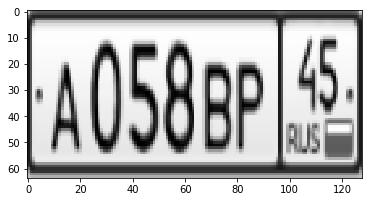

(2) : The_labels (labels): A058BP45 is encoded as [10, 0, 5, 8, 11, 18, 4, 5]
(3) : Length of Input Image(input_length) fed into the loss function : 30 == 128 / 4 - 2
(4) : Length of plate number(label_length) : 8
__________________________________________________________________________________________________________________

Text Generator Output (data which we feed into RNN)
(1) : The Input Image(the_input): Shape of Image fed to the RNN : (128, 64)


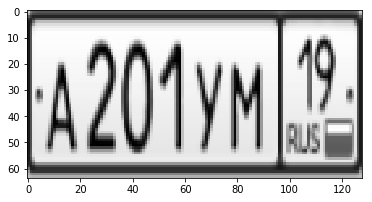

(2) : The_labels (labels): A201YM19 is encoded as [10, 2, 0, 1, 21, 16, 1, 9]
(3) : Length of Input Image(input_length) fed into the loss function : 30 == 128 / 4 - 2
(4) : Length of plate number(label_length) : 8
__________________________________________________________________________________________________________________

Text Generator Output (data which we feed into RNN)
(1) : The Input Image(the_input): Shape of Image fed to the RNN : (128, 64)


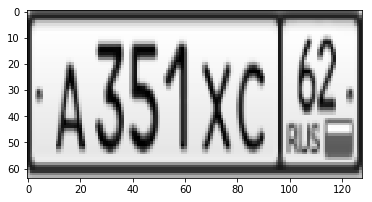

(2) : The_labels (labels): A351XC62 is encoded as [10, 3, 5, 1, 20, 12, 6, 2]
(3) : Length of Input Image(input_length) fed into the loss function : 30 == 128 / 4 - 2
(4) : Length of plate number(label_length) : 8
__________________________________________________________________________________________________________________


In [10]:
print_samples = 0

# generated a batch of 8 samples
for inputs, outputs in val_data.next_batch():
    if print_samples == 3:
        break
    
    print("\nText Generator Output (data which we feed into RNN)")
    img = inputs['the_input'][0, :, :, 0]
    print("(1) : The Input Image(the_input): Shape of Image fed to the RNN : {}".format(img.shape))
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('(2) : The_labels (labels): {} is encoded as {}'.format(labels_to_text(inputs['the_labels'][0]), 
                                                                                 list(map(int, inputs['the_labels'][0]))))
    print("(3) : Length of Input Image(input_length) fed into the loss function : %d == %d / 4 - 2"%(inputs['input_length'][0],
                                                                                             val_data.img_w))
    print("(4) : Length of plate number(label_length) : %d"%(inputs['label_length'][0]))
    print('__'*57)
    
    print_samples += 1
    
    

## 1.4 - Connectionist Temporal Classification(CTC) loss

- CTC is a special kind of loss function used in sequence modelling where input is a sequence like audio, text, handwritten texts etc..
- For a given Image rather than reproducing the text_label that is assosiated with time,  ctc_loss chooses the best label out of all possible labels.
<font color='green'>
    
- I suggest you read distill pub blog (https://distill.pub/2017/ctc/) for understanding.

In [11]:
def ctc_lambda_func(args):
    
    y_pred, labels, input_length, label_length = args
    
    # the 2 is critical here because the first 2 outputs of RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(y_true=labels, y_pred=y_pred, input_length=input_length, label_length=label_length)

## 1.5 - Network Architecture

- We use a convolutional stack of layers followed by a recurrent stack and a CTC logloss function to perform OCR.

In [12]:
def train_model(img_w):
    
    # input parameter
    img_h = 64
    
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    
    # keras tf convention
    inp_shape = (img_w, img_h, 1)
    
    batch_size = 32
    downsample_factor = pool_size ** 2 
    
    train_data = TextImageGenerator('data/train/', img_w, img_h, batch_size, downsample_factor)
    train_data.build_data()
    
    val_data = TextImageGenerator('data/val/', img_w, img_h, batch_size, downsample_factor)
    val_data.build_data()
    
    
    X_input = Input(shape=inp_shape, name='the_input', dtype='float32')
    
    # two convolutional layers
    X = Conv2D(conv_filters, kernel_size, padding='same', activation='relu', kernel_initializer='he_normal',
              name='conv1')(X_input)
    X = MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool1')(X)
    
    X = Conv2D(conv_filters, kernel_size, padding='same', activation='relu', kernel_initializer='he_normal',
              name='conv2')(X)
    X = MaxPooling2D(pool_size=(pool_size, pool_size), name='maxpool2')(X)
    
    
    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2))* conv_filters)
    X = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(X)
    
    # cuts down the input_size going into  RNN
    X = Dense(time_dense_size, activation='relu', name='dense1')(X)
    
    
    # two layers of bidirectional GRUs
    gru_1a = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru_1a')(X)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal',
                name='gru_1b')(X)
    
    # adding the values of two grus
    gru1_merged = add([gru_1a, gru_1b])
    
    gru_2a = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru_2a')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', 
                 name='gru_2b')(gru1_merged)
    
    # tranform RNN outputs to character activations ie (ie,. 22 characters in letters + '-' blank character)
    X = Dense(train_data.get_output_size(), kernel_initializer='he_normal', 
              name='dense2')(concatenate([gru_2a, gru_2b]))
    
    y_pred = Activation('softmax', name='softmax')(X)
    
    Model(inputs=X_input, outputs=y_pred).summary()
    
    # max_text_len = 8
    labels = Input(name='the_labels', shape=[8], dtype='float32')
    input_length = Input(name = 'input_length', shape=[1], dtype='int64')
    label_length = Input(name = 'label_length', shape=[1], dtype='int64')
    
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a Lambda layer
    ctc_loss_out = Lambda(ctc_lambda_func, output_shape=(1, ), 
                          name='ctc')([y_pred, labels, input_length, label_length])
    
    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    model = Model(inputs=[X_input, labels, input_length, label_length], outputs=ctc_loss_out)
    
    model.compile(loss = {'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([X_input], [y_pred])
        
    model.fit_generator(generator=train_data.next_batch(), 
                            steps_per_epoch=train_data.n,
                            epochs=1, 
                            validation_data=val_data.next_batch(), 
                            validation_steps=val_data.n)
    
    return model

## 1.6 - Training the model

- Our training set contains of 10K images, so using a midrange nvidia_gpu takes ~1 hour to train.

In [12]:
model = train_model(img_w=128)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320     

- The trained model 

### 1.6.1 - Saving Model

- If the model has fit/achieved decent accuracy on training set, save it for further use

In [22]:
# serialize model to json
ocr_model_json = model.to_json()
with open("ocr_model.json", 'w') as json_file:
    json_file.write(ocr_model_json)
    
# save model weights    
model.save_weights("ocr_model_weights.h5")
print("Model Saved to disk")

Model Saved to disk


### 1.6.2 - Reload Model if working multiple times

In [13]:
#load json and create new model
json_file = open('ocr_model.json', 'r')
loaded_json_model = json_file.read()
json_file.close()

model = model_from_json(loaded_json_model)

#load weights
model.load_weights('ocr_model_weights.h5')

## 1.7 - Function to decode neural network output

- For real world applications, beam search is used with a dictionary and language model.
- Here best path or greedy search is sufficient.
- Retrive the layers, `input_layer` to feed in the batch_test_data and `output_layer` to extract the activations of that batch.

In [14]:
# First layer defined in our trained model. test_data is fed through this layer.
model_input_layer = model.get_layer(name='the_input').input

# Last softmax layer defined in our trained model. Given input data , this layer makes predictions
model_output_layer = model.get_layer(name='softmax').output

In [23]:
from itertools import groupby

def decode_batch(out):
    batch_text = []
    # loops over the current_batch
    for j in range(out.shape[0]):
        # lists out the highest probable indices from each row of activations(30, 23)
        most_prob_indices = list(np.argmax(out[j, 2:], axis=1))                          # outputs [AAAA__BBB_C_DD]
        most_prob_indices = [unique for unique, group in groupby(most_prob_indices)]     # outputs [A_B_C_D]
        out_text = ''
        for idx in most_prob_indices:
            if idx < len(letters):        # 22 index is '-' blank char
                out_text += letters[idx]
        batch_text.append(out_text)       # outputs('ABCD')
        
    return batch_text

## 1.8 - Evaluating on Testing set

- We'll predict the characters using our trained model.
- We'll also see how the softmax layer activations correspond to the activations.

In [24]:
test_data = TextImageGenerator(dirpath='data/test/', img_w=128, img_h=64, batch_size=8, downsample_factor=4)
test_data.build_data()

print("Number of samples in test set : ", test_data.n_samples())

Number of samples in test set :  561


In [56]:
def print_predictions(data, plot_act_img=False):

    for input_samples, out in data.next_batch():
        batch_size = input_samples['the_input'].shape[0]
        X_data = input_samples['the_input']
        # Run the test data through the model graph to extract the activations
        model_out_value = sess.run(model_output_layer, feed_dict={model_input_layer : X_data})
        pred_texts = decode_batch(model_out_value)
        labels = input_samples['the_labels']
        texts = []
    
        for label in labels:
            text = ''.join(list(map(lambda x: letters[int(x)], label)))
            texts.append(text)
            
        print("****************************")
        print("Batch Accuracy : " + str(np.mean(np.array(pred_texts) == np.array(texts))*100), "%")
        print("****************************")
    
        for i in range(batch_size):
            fig = plt.figure(figsize=(10, 10))
            outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
            ax1 = plt.Subplot(fig, outer[0])
            fig.add_subplot(ax1)
            ax2 = plt.Subplot(fig, outer[1])
            fig.add_subplot(ax2)
            print("PREDICTED  : %s\nTRUE LABEL : %s" % (pred_texts[i], texts[i]))
            
            if plot_act_img:
                img = X_data[i][:, :, 0].T
                ax1.set_title('Input IMAGE')
                ax1.imshow(img, cmap='gray')
                ax1.set_xticks([])
                ax1.set_yticks([])
            
                ax2.set_title('ACTIVATIONS OF SOFTMAX LAYER')
                ax2.imshow(model_out_value[i].T, cmap='binary', interpolation='nearest')
                ax2.set_yticks(list(range(len(letters) + 1)))
                ax2.set_yticklabels(letters + ['blank'])
                ax2.grid(False)
                for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
                    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
            plt.show()
            print('__'*56)
        break

****************************
Batch Accuracy : 100.0 %
****************************
PREDICTED  : E306BE01
TRUE LABEL : E306BE01


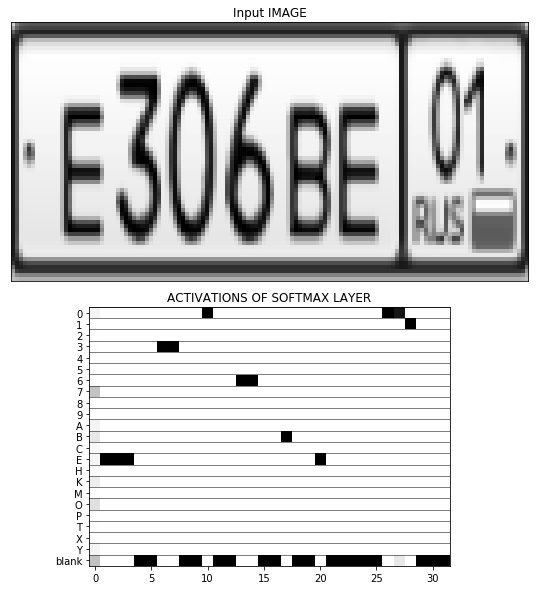

________________________________________________________________________________________________________________
PREDICTED  : E336XH15
TRUE LABEL : E336XH15


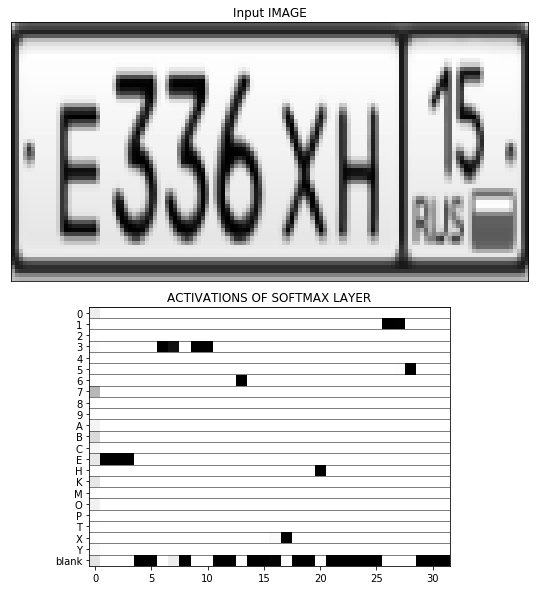

________________________________________________________________________________________________________________
PREDICTED  : E343OO27
TRUE LABEL : E343OO27


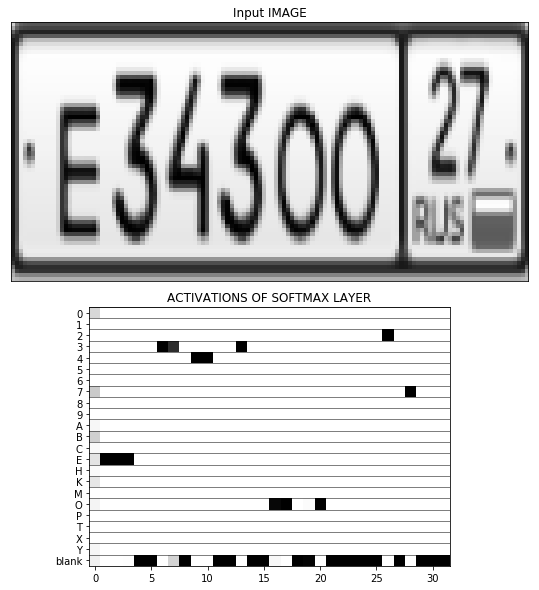

________________________________________________________________________________________________________________
PREDICTED  : E403OK73
TRUE LABEL : E403OK73


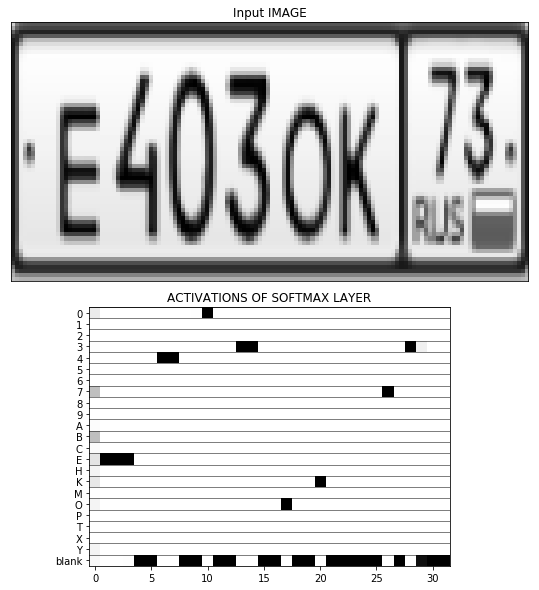

________________________________________________________________________________________________________________
PREDICTED  : E425KY88
TRUE LABEL : E425KY88


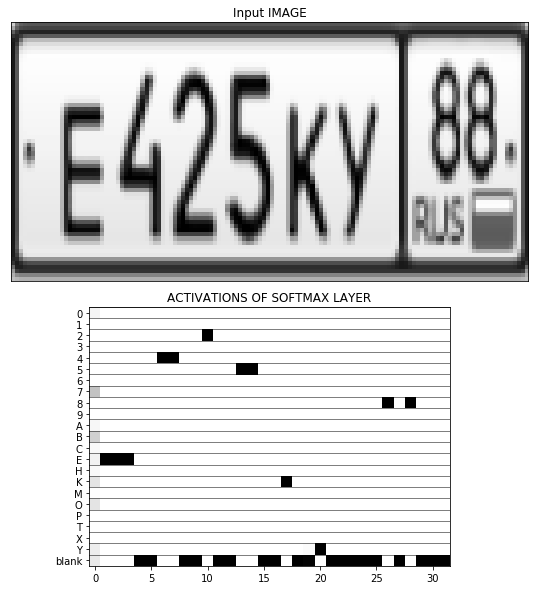

________________________________________________________________________________________________________________
PREDICTED  : E425MT47
TRUE LABEL : E425MT47


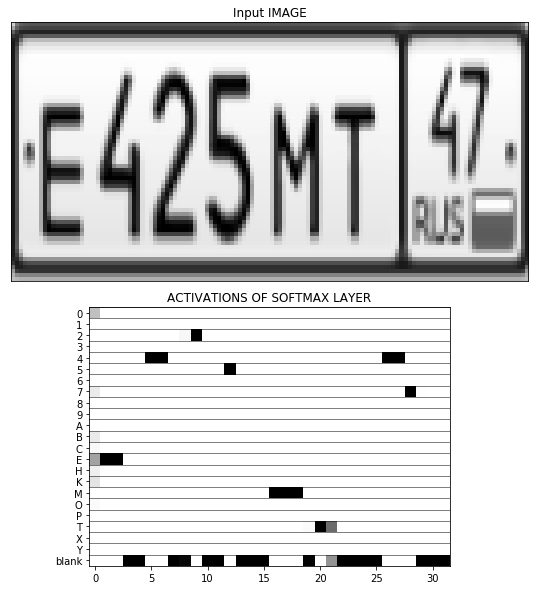

________________________________________________________________________________________________________________
PREDICTED  : E440CX78
TRUE LABEL : E440CX78


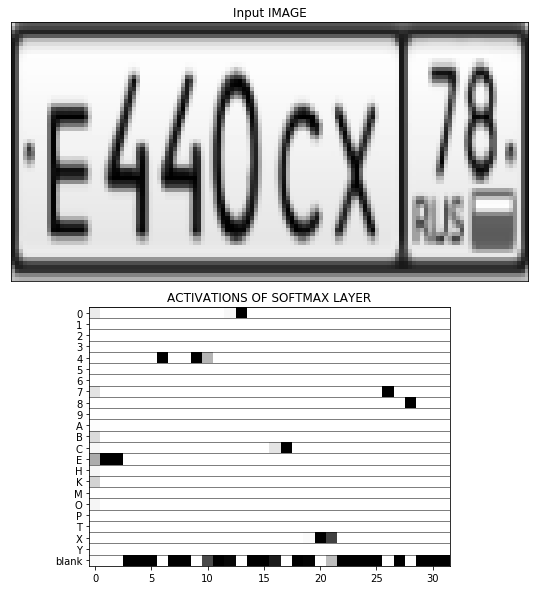

________________________________________________________________________________________________________________
PREDICTED  : E441EP77
TRUE LABEL : E441EP77


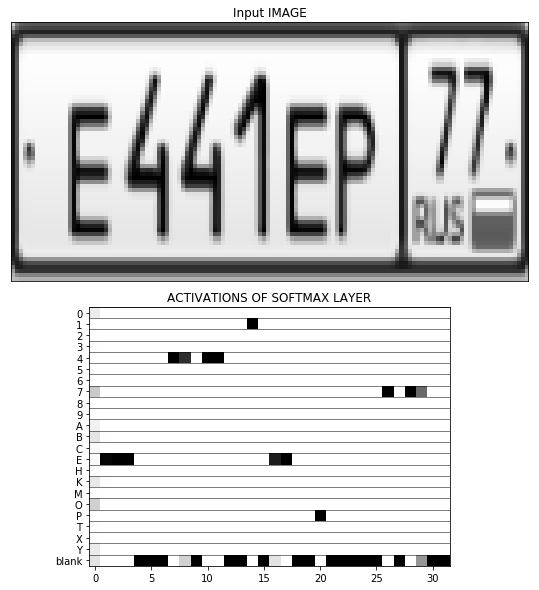

________________________________________________________________________________________________________________


In [58]:
print_predictions(test_data, plot_act_img=True)

<font color='blue'>
    ** Observations :**
    
- See our model accurately predicts the labels all most all the time with great accuracy.(~99.9%)
- If you observe the activations map carefully, the actiavtions at a particular time step contribute to the probability of that character.
- Suppose we have an input image with label `cat`, then the output of the model with ctc loss will be `ccc--aaa---ttt`,
 First the repeated characters are merged to `c-a-t`, then blanks are removed to output `cat`.

<font color='red'>
    ** Note :**
    
- This model is trained only on car number plates, so it may be able to recognize similar number plates. But if this trained model is used on other OCR images such as `handwritten text`, it may not be able to generalize to those images due to change in distribution of the testing data.

## 1.9 - References

- Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks by Alex Graves(2006) (http://www.cs.toronto.edu/~graves/icml_2006.pdf)

- End-to-End Deep Neural Network for Automatic Speech Recognition (https://cs224d.stanford.edu/reports/SongWilliam.pdf)

- End-2-End Deep Learning slides by deep systems(https://goo.gl/SGL5fr)

- CTC Loss slides by deep systems (https://goo.gl/VwkJb7)